In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [31]:
import seaborn as sns
import seaborn.objects as so
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import Colormap, Normalize
from typing import Iterable
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import MinMaxScaler

from setup.data_wrangle import *
from setup.materials_setup import *
from analysis.materials_compare import *
from analysis.helpers import *
from analysis.plot_helpers import *
from network.network import init_multigraph
from analysis.volumes import aggregate_and_compare


sns.set_theme()


In [8]:
df_vol, sc = init_df()




In [22]:
df_vol.head(2)

case_names,space_names,datetimes,qoi,values,qoi_0,values_0,qoi_1,values_1,material_type
str,str,datetime[μs],str,f64,str,f64,str,f64,str
"""Light_case_amb_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:00:00,"""AFN Zone Ventilation Volume""",133.791852,"""AFN Zone Mixing Volume""",45.786314,"""Zone Mean Air Temperature""",19.856057,"""Light"""
"""Light_case_amb_b1""","""BLOCK 00 STOREY 0""",2017-07-01 00:15:00,"""AFN Zone Ventilation Volume""",125.561749,"""AFN Zone Mixing Volume""",76.304095,"""Zone Mean Air Temperature""",19.221054,"""Light"""


In [36]:
df_agg, g = aggregate_and_compare_materials(df_vol)

In [37]:
g.show()

In [24]:
df_agg = aggregate_and_compare(df_vol)
df_agg

case_names,vent,mixing,combined_vent,temp
str,f64,f64,f64,f64
"""Light_case_amb_b1""",91.856537,360.6783,452.534837,22.944282
"""Heavy_case_bol_5""",341.334826,271.456674,612.7915,23.144181
"""Light_case_bol_5""",326.805603,248.84259,575.648193,22.914396
"""Heavy_case_red_b1""",240.200092,388.258176,628.458268,22.311974
"""Medium_case_bol_5""",340.079384,250.772877,590.852261,23.040847
"""Medium_case_red_b1""",246.739708,395.707333,642.447041,22.208548
"""Heavy_case_amb_b1""",93.229878,364.582466,457.812345,23.16201
"""Medium_case_amb_b1""",91.36269,353.926941,445.28963,23.111333
"""Light_case_red_b1""",244.839064,389.61218,634.451244,22.134336


In [26]:
df_agg2 = df_agg.with_columns(
        material_type=pl.when(pl.col("case_names").str.contains("Light"))
        .then(pl.lit("Light"))
        .when(pl.col("case_names").str.contains("Medium"))
        .then(pl.lit("Medium"))
        .otherwise(pl.lit("Heavy")),
        case_type = pl.when(pl.col("case_names").str.contains("amb"))
        .then(pl.lit("amb"))
        .when(pl.col("case_names").str.contains("bol"))
        .then(pl.lit("bol"))
        .otherwise(pl.lit("red")),
    )

In [27]:
df_agg2

case_names,vent,mixing,combined_vent,temp,material_type,case_type
str,f64,f64,f64,f64,str,str
"""Light_case_amb_b1""",91.856537,360.6783,452.534837,22.944282,"""Light""","""amb"""
"""Heavy_case_bol_5""",341.334826,271.456674,612.7915,23.144181,"""Heavy""","""bol"""
"""Light_case_bol_5""",326.805603,248.84259,575.648193,22.914396,"""Light""","""bol"""
"""Heavy_case_red_b1""",240.200092,388.258176,628.458268,22.311974,"""Heavy""","""red"""
"""Medium_case_bol_5""",340.079384,250.772877,590.852261,23.040847,"""Medium""","""bol"""
"""Medium_case_red_b1""",246.739708,395.707333,642.447041,22.208548,"""Medium""","""red"""
"""Heavy_case_amb_b1""",93.229878,364.582466,457.812345,23.16201,"""Heavy""","""amb"""
"""Medium_case_amb_b1""",91.36269,353.926941,445.28963,23.111333,"""Medium""","""amb"""
"""Light_case_red_b1""",244.839064,389.61218,634.451244,22.134336,"""Light""","""red"""


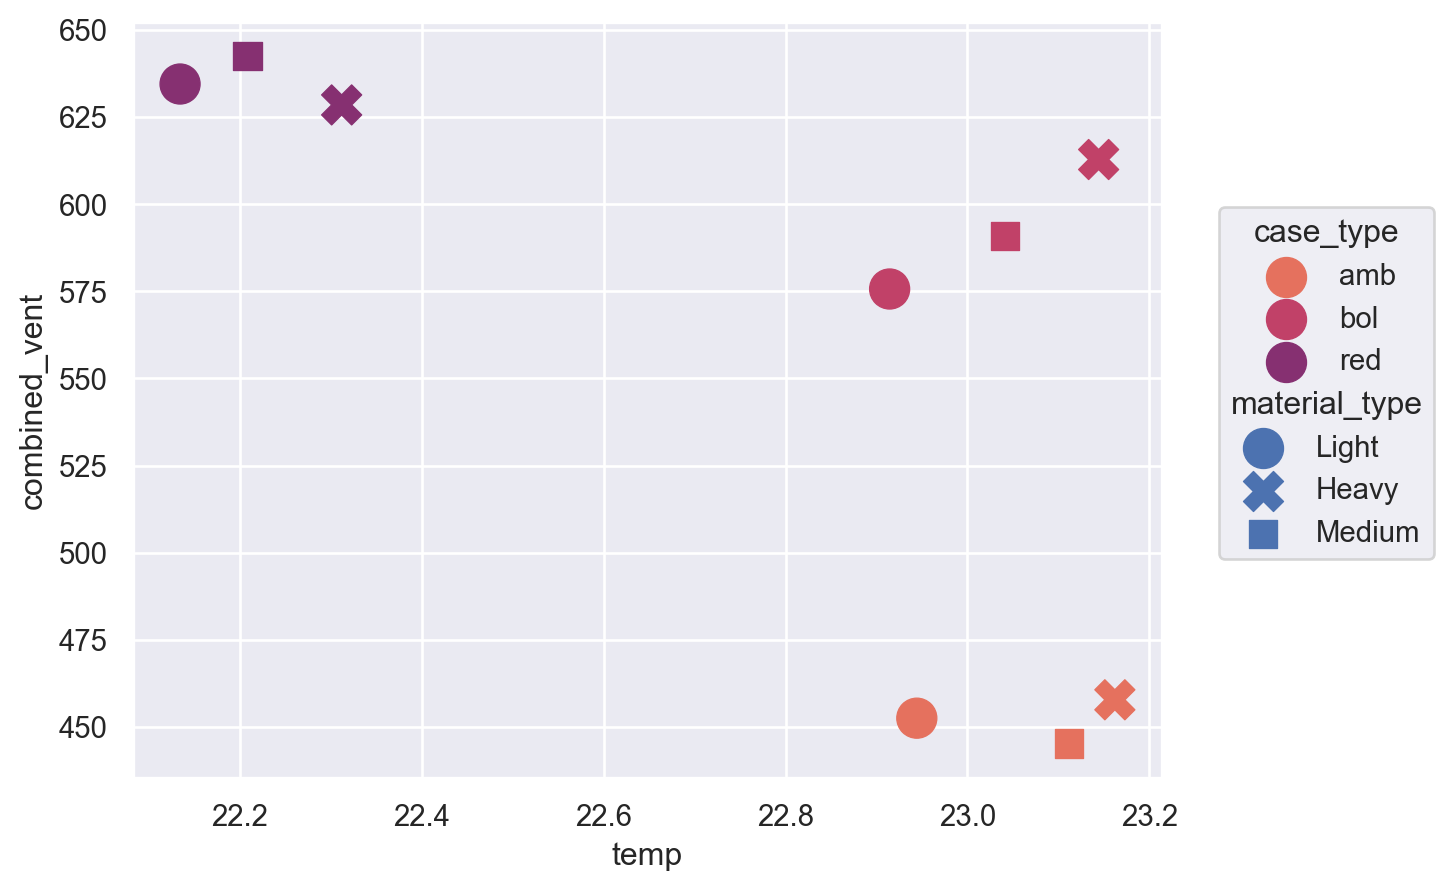

In [35]:
(so.Plot(df_agg2, x="temp", y="combined_vent", color="case_type", marker="material_type" ).add(so.Dot(pointsize=15)).scale(color="flare").plot())